# Wrangle OpenStreetMap Data

In this project I will have a look at the OpenStreeMap data of the area around Zürich in Switzerland. The goal is to apply data wrangling techniques to asses the data quality and clean possible uniformities and inconsistencies. Finally, the data will be passed to a structured SQL database using the SQLite engine. Basic SQL querries and aggregations as well as the `sqlite3` Python API will be used to gather statistics and interesting insights about the data set.

During the project the following Python libraries were used:

In [1]:
import csv
import matplotlib.pyplot as plt
% matplotlib inline
import mplleaflet
import pprint
import re
import sqlite3
import xml.etree.cElementTree as ET

The `csv` and `xml` libraries were used for data gathering and parsing while `sqlite3` was required for database interactions. `mplleaflet` is a simple library that allows to convert `matplotlib` visualisations into zoomable Leaflet maps.

## Map Area

Zürich, Switzerland

[https://www.openstreetmap.org/relation/1682248](https://www.openstreetmap.org/relation/1682248)

## Data Exploration

I created a few simple helper functions to explore the xml data. The following ones were used to count the different root elements and their children to get a feeling for the structure and dimensions of the file. 

In [2]:
def get_roots(file_name, root_tags=['node', 'way', 'relation']):
    """Return a dictionary containing the different specified root elements and their number of occurences in the input file."""
    roots = {}
    for event, elem in ET.iterparse(file_name, events=('end',)):
        if elem.tag in root_tags:
            if elem.tag in roots:
                roots[elem.tag] += 1
            else:
                roots[elem.tag] = 1
            
    return roots


def get_childs(file_name, root):
    """Return a dictionary containing the different childs and their number of occurences for the specified root element."""
    childs = {}
    for event, elem in ET.iterparse(file_name, events=('end',)):
        if elem.tag == root:
            for child in elem:
                if child.tag in childs:
                    childs[child.tag] += 1
                else:
                    childs[child.tag] = 1
    
    return childs


def get_attributes(file_name, root, child_tag=None):
    """
    Return the attributes and their number of occurences for the root element. If child_tag is specified, return the attributes 
    of the child element.
    """
    attributes = {}
    for event, elem in ET.iterparse(file_name, events=('end',)):
        if elem.tag == root:
            # get attributes of child
            if child_tag:
                for child in elem.iter(child_tag):
                    for k in child.keys():
                        if k in attributes:
                            attributes[k] += 1
                        else:
                            attributes[k] = 1
            # get attributes of root  
            else:
                for k in elem.keys():
                    if k in attributes:
                        attributes[k] += 1
                    else:
                        attributes[k] = 1
    
    return attributes


def get_file_structure(file_name):
    """
    Count the root and child elements and their tags for the xml file with 2 levels. 
    """
    # get root element counts
    roots = get_roots(file_name)

    # get children for all root elements
    childs = {}
    for r in roots.keys():
        childs[r] = get_childs(file_name, r)
    
    # collect attributes for all root elements
    root_attributes = {}
    for r in roots.keys():
        root_attributes[r] = get_attributes(file_name, r)
    
    # gather attributes for all the differen child elements
    child_attributes = {}
    for r in roots.keys():
        child_attributes[r] = {}
        for c in childs[r].keys():
            child_attributes[r][c] = get_attributes(file_name, r, c)
    
    return (root_attributes, child_attributes)

From the printouts of the functions above I could get a clear picture of the tree structure of the OSM XML file.

```xml
<node id lat lon user uid version changeset timestamp> [2 018 926]
    <tag k v /> [340 957]
</node>
<way id user uid version changeset timestamp> [302 080]
    <tag k v /> [936 274]
    <nd ref /> [2 530 372]
</way>
<relation id user uid version changeset timestamp> [4 765]
    <tag k v /> [21 916]
    <member ref role type /> [135 999]
</relation>
```

We can see that the data is split into three different root element categories: node, way, and relation. 

Nodes consist of single points in space defined by their latitude and longitude. Ways contain tags and ordered lists of nodes that define their shape. This nodes are clearly identified by the unique node id in the `ref` attribute of their `nd` children. Relations are used to describe logical or geographical relationships between their member childrens than can either be `node` or `way` types. All three different root elements can have `tag` children that contain further information stored as key and value pairs. The numbers inbetween square brackets denote the number of occurences of the element in that line.

My next step in the data exploration process was to have a look at the different keys and values that appear in the `tag` children of the different root elements. For this purpose I wrote the two functions below. They can be used to count the different keys in the tag children of the specified root element and to count the different values associated with a certain key.

In [3]:
def get_tag_keys(file_name, roots):
    tag_keys = {}
    for event, elem in ET.iterparse(file_name, events=('end',)):
        if elem.tag in roots:
            for tag in elem.iter('tag'):
                k = tag.attrib['k']
                if k in tag_keys:
                    tag_keys[k] += 1
                else:
                    tag_keys[k] = 1
    
    # sort tag keys based on numer of occureces
    sorted_tag_keys = sorted(tag_keys.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_tag_keys


def get_tag_key_values(file_name, roots, tag_key):
    tag_key_values = {}
    for event, elem in ET.iterparse(file_name, events=('end',)):
        if elem.tag in roots:
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == tag_key:
                    v = tag.attrib['v']
                    if v in tag_key_values:
                        tag_key_values[v] += 1
                    else:
                        tag_key_values[v] = 1
    
    
    # sort tag key values based on number of occureces
    sorted_tag_key_values = sorted(tag_key_values.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_tag_key_values

To show how these functions work, they will be used in the code block below to print out the most frequent keys within all tag elements and the different surface type values that occur in way root elements. 

In [4]:
# osm xml file
file = 'zurich.osm'

# different keys within all root elements
tag_keys = get_tag_keys(file, ['node', 'way', 'relation'])

# most frequent values associated with "building" key
way_tag_surface_values = get_tag_key_values(file, ['way'], 'surface')

# print out top 20 entries of both lists
print("")
pprint.pprint(tag_keys[:20])
print()
pprint.pprint(way_tag_surface_values[:20])


[('building', 166384),
 ('natural', 122355),
 ('addr:housenumber', 115076),
 ('addr:street', 114126),
 ('highway', 101397),
 ('addr:postcode', 69465),
 ('addr:city', 62461),
 ('name', 56466),
 ('source', 56377),
 ('addr:country', 46087),
 ('amenity', 19836),
 ('tracktype', 15704),
 ('surface', 15536),
 ('operator', 14175),
 ('maxspeed', 13502),
 ('landuse', 13022),
 ('service', 10504),
 ('railway', 9597),
 ('foot', 9434),
 ('power', 8917)]

[('asphalt', 5570),
 ('gravel', 3771),
 ('paved', 2680),
 ('ground', 883),
 ('unpaved', 770),
 ('grass', 561),
 ('dirt', 214),
 ('paving_stones', 195),
 ('cobblestone', 141),
 ('pebblestone', 137),
 ('compacted', 119),
 ('concrete', 119),
 ('wood', 89),
 ('sand', 49),
 ('fine_gravel', 36),
 ('sett', 26),
 ('tartan', 25),
 ('mud', 19),
 ('metal', 18),
 ('paving-stones', 15)]


## Data Auditing - Problems Encountered in the Map

While browsing trough the values of some tag key attributes I did not discover any major data inconsistencies but only a few formatting variations. I noticed four main formatting problems:

* Housenumbers in Switzerland are sometimes combinations of numbers and letters. Flats in the same apartement building for example might have the same housenumber but are then distinguished by adding a letter after the number (1A, 1B, 1C,...). I want all of these letters to be uppercase.

* If cities or villages with the same name appear in multiple locations, they are usually suffixed with abbreviation of the state they are in. For the canton of Zürich, this abbreviation is ZH. I want all locations that have this suffix to be in the same format, "(ZH)". Furthermore, I want to fix a few abbreviations that occur, such as b., a., a.A..

* Not all website values have the same formatting. I will harmonize them so that each entry starts with "http://www.".

* The format for phone numbers should be standardized to "+41 xx xxx xx xx".

The `audit()` function below was used to print out data entries that do not follow the desired specifications. This allowed to see which patterns needed to be cleaned.

In [5]:
def is_key(elem, key):
    """Check if the passed element contains the specified key."""
    return (elem.attrib['k'] == key)


# audit housenumber
def audit_house_number(house_number, bad_house_numbers):
    """Check if house_number passed contains a lowercase letter. If so add it to the bad_house_number set."""
    if any(c.islower() for c in house_number):
        bad_house_numbers.append(house_number)

        
# audit addr:city
def audit_city(city, bad_cities):
    """Check if passed city contains an abbreviation or any form of ZH. Add tht city to the bad_cities set if any test 
    succeeds.
    """
    city_abbrev_re = re.compile('\.')
    city_zh_re = re.compile('ZH')
    
    m1 = city_abbrev_re.search(city)
    m2 = city_zh_re.search(city)
    
    if m1 or m2:
        bad_cities.append(city)

        
# audit phone
# +41 xx xxx xx xx
def audit_phone_number(phone_number, bad_phone_numbers):
    # check if phone number follows the standard format
    phone_number_re = re.compile('\+[0-9]{2} [0-9]{2} [0-9]{3} [0-9]{2} [0-9]{2}')
    
    m = phone_number_re.search(phone_number)
    
    if not m:
        bad_phone_numbers.append(phone_number)
    
    
# audit website
# starts with http://www.
def audit_website(website, bad_websites):
    # check if website starts with http://www.
    website_re = re.compile('^https?://www.')
    
    m = website_re.search(website)
    
    if not m:
        bad_websites.append(website)

bad_house_numbers = []
bad_cities = []
bad_phone_numbers = []
bad_websites = []


def audit(file_name):
    for event, elem in ET.iterparse(file_name, events=('end',)):
        if elem.tag in ['node', 'way', 'relation']:
            for tag in elem.iter('tag'):
                if is_key(tag, 'addr:housenumber'):
                    audit_house_number(tag.attrib['v'], bad_house_numbers)
                elif is_key(tag, 'addr:city'):
                    audit_city(tag.attrib['v'], bad_cities)
                elif is_key(tag, 'phone'):
                    audit_phone_number(tag.attrib['v'], bad_phone_numbers)
                elif is_key(tag, 'website'):
                    audit_website(tag.attrib['v'], bad_websites)

To address all the issues shown above I created cleaning functions that will be applied to the respective tag values before storing them in the csv files that will be imported into the database.

In [6]:
# cleaning functions
def clean_house_number(house_number):
    if any(c.islower() for c in house_number):
        for i, c in enumerate(house_number):
            if c.islower() and (i == len(house_number) - 1 or house_number[i + 1] == "," or house_number[i + 1] == " "):
                house_number = "{}{}{}".format(house_number[:i], c.upper(), house_number[i + 1:])

    return house_number


def clean_phone_number(phone_number):
    phone_number_re = re.compile('\+[0-9]{2} [0-9]{2} [0-9]{3} [0-9]{2} [0-9]{2}')
    m = phone_number_re.search(phone_number)
    
    if not m:
        # remove '(0)', '-' and ' '
        for ch in ["-", "(0)", " "]:
            if ch in phone_number:
                phone_number = phone_number.replace(ch, "")
        
        # set correct starting sequence 
        if phone_number[:3] != "+41":
            if phone_number[:2] == "04" or phone_number[:2] == "07":
                phone_number = "+41{}".format(phone_number[1:])
        
        # set spacing
        phone_number = "{} {} {} {} {}".format(phone_number[:3], phone_number[3:5], phone_number[5:8], 
                                               phone_number[8:10], phone_number[10:])

    return phone_number


def clean_website(website):
    website_re = re.compile('^https?://www.')
    m = website_re.search(website)
    
    if not m:
        if website[:4] == "www.":
            website = "http://{}".format(website)
        elif website[:7] == "http://" and "www." not in website:
            website = "{}www.{}".format(website[:7], website[7:])
        elif website[:8] == "https://" and "www." not in website:
            website = "{}www.{}".format(website[:8], website[8:])
        else:
            website = "http://{}".format(website)
            
    return website


def clean_city(city):
    city_abbrev_re = re.compile('\.')
    city_zh_re = re.compile('ZH')
    
    m1 = city_abbrev_re.search(city)
    if m1:
        map = [["a.", "am"], ["A.", " Albis"], ["b.", "bei"]]
        for m in map:
            city = city.replace(m[0], m[1])

    m2 = city_zh_re.search(city)
    if m2:
        if "(ZH)" not in city:
            city = city.replace("ZH", "(ZH)")

    return city

## SQL Database

To be able to store the OSM data in a SQL database, the xml input file will be transformed into a tabular dictionary format. This format can easily be stored in csv files which will then be imported into the different SQL tables.

The `shape_element()` function takes an iterparse element object as input and returns a formatted dictionary. If the element top level tag is equal to "node", the function will return the following dictionary structure:
```
{'node': {'node_id': ...,
          'lat': ...,
          'lon': ...,
          'user': ...,
          'uid': ...,
          'version': ...,
          'changeset': ...,
          'timestamp': ...},
 'node_tags': [{'node_id': ...,
               'key': ...,
               'value': ...,
               'type': ...},
               {'node_id': ...,
               'key': ...,
               'value': ...,
               'type': ...},
               ...]
}
```
The `node` field contains all the attributes of the node root element. The `node_tags` field contains a list with dictionaries for all the secondary tag children of the passed root element. 'node_tags' entries are are connected to their parent elements based on the unique `node_id` values. Furthermore, if the tag `k` attribute contains any problematic characters, the tag is ignored, but if the tag contains a ":", the tag `type` well be set to the characters coming before the ":". If the tag key does not contain a colon, the `type` field will be set to "regular". Before any `v` attributes are written to the `value` field, they are cleaned using the cleaning functions from the section above.

Similar dictionaries are shaped for "way" and "relation" root elements.

In [7]:
# keys for the dictionaries to be shaped for the different root elements
node_fields = ['node_id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
node_tag_fields = ['node_id', 'key', 'value', 'type']

way_fields = ['way_id', 'user', 'uid', 'version', 'changeset', 'timestamp']
way_tag_fields = ['way_id', 'key', 'value', 'type']
way_node_fields = ['way_id', 'node_id', 'position']

relation_fields = ['relation_id', 'user', 'uid', 'version', 'changeset', 'timestamp']
relation_tag_fields = ['relation_id', 'key', 'value', 'type']
relation_member_fields = ['relation_id', 'type', 'node_id', 'way_id', 'role']

# regex for characters we do not want in the tag keys
problem_chars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def shape_element(elem, node_attr_fields=node_fields, way_attr_fields=way_fields, relation_attr_fields=relation_fields,
                  problem_chars=problem_chars, default_tag_type='regular'):
    """Clean and shape node, way and relation root elements to dictionaries."""
    
    node_attribs = {}
    way_attribs = {}
    relation_attribs = {}
    
    way_nodes = []
    relation_members = []
    
    tags = []  # handle secondary tags the same way for node, way and relation elements
    
    if elem.tag == 'node':
        # shape dictionary for 'node' element attributes
        for field in node_fields:
            if field == 'node_id':
                node_attribs[field] = elem.attrib['id']
            else:
                node_attribs[field] = elem.attrib[field]
    
    elif elem.tag == 'way':
        # shape dictionary for 'way' element attributes
        for field in way_fields:
            if field == 'way_id':
                way_attribs[field] = elem.attrib['id']
            else:
                way_attribs[field] = elem.attrib[field]
        
        # 'nd' children of 'way' elements
        position = 0    
        for node in elem.iter('nd'):
            node_dict = {}
            
            node_dict['way_id'] = elem.attrib['id']
            node_dict['node_id'] = node.attrib['ref']
            node_dict['position'] = position
            
            way_nodes.append(node_dict) 
            position += 1
    
    elif elem.tag == 'relation':
        # shape dictionary for 'relation' element attributes
        for field in relation_fields:
            if field == 'relation_id':
                relation_attribs[field] = elem.attrib['id']
            else:
                relation_attribs[field] = elem.attrib[field]
        
        # 'member' children of 'way' elements   
        for member in elem.iter('member'):
            member_dict = {}

            member_dict['relation_id'] = elem.attrib['id']
            member_dict['type'] = member.attrib['type']
                
            if member.attrib['type'] == 'node':
                member_dict['node_id'] = member.attrib['ref']
                member_dict['way_id'] = None
            else:
                member_dict['way_id'] = member.attrib['ref']
                member_dict['node_id'] = None
                
            member_dict['role'] = member.attrib['role']
                
            relation_members.append(member_dict)
    
    for child in elem:
        # 'tag' children of all root elements
        if child.tag == 'tag':
            if problem_chars.match(child.attrib['k']):
                print(child.attrib['k'])
                continue
            else:
                tag_dict = {}
                
                if elem.tag == 'node':
                    tag_dict['node_id'] = elem.attrib['id']
                elif elem.tag == 'way':
                    tag_dict['way_id'] = elem.attrib['id']
                elif elem.tag == 'relation':
                    tag_dict['relation_id'] = elem.attrib['id']
                
                if ':' not in child.attrib['k']:
                    tag_dict['key'] = child.attrib['k']
                    tag_dict['type'] = default_tag_type
                else:
                    loc = child.attrib['k'].find(':')
                    tag_dict['key'] = child.attrib['k'][loc + 1:]
                    tag_dict['type'] = child.attrib['k'][:loc]
                
                # cleaning of tag values
                if tag_dict['key'] == 'phone':
                    phone_number = child.attrib['v']
                    phone_number = clean_phone_number(phone_number)
                    tag_dict['value'] = phone_number
                elif tag_dict['key'] == 'website':
                    website = child.attrib['v']
                    website = clean_website(website)
                    tag_dict['value'] = website
                elif tag_dict['key'] == 'city':
                    city = child.attrib['v']
                    city = clean_city(city)
                    tag_dict['value'] = city
                elif tag_dict['key'] == 'housenumber':
                    house_number = child.attrib['v']
                    house_number = clean_house_number(house_number)
                    tag_dict['value'] = house_number
                else:
                    tag_dict['value'] = child.attrib['v']
                
            tags.append(tag_dict)

    if elem.tag == 'node':
        return {'node': node_attribs, 'node_tags': tags}
    elif elem.tag == 'way':
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}
    elif elem.tag == 'relation':
        return {'relation': relation_attribs, 'relation_members': relation_members, 'relation_tags': tags}

The shaping functions is used to convert the XML elements into a format that can easily be stored in a csv file. Each csv file will later represent a distinct table in the SQL database. The `convert_to_csv()` function iterates trough the all root elements, collects the data for each one in a shaped dictionary and writes them line-by-line to the different output files.

In [8]:
# csv file paths
nodes_path = "nodes.csv"
nodes_tags_path = "nodes_tags.csv"

ways_path = "ways.csv"
ways_tags_path = "ways_tags.csv"
ways_nodes_path = "ways_nodes.csv"

relations_path = "relations.csv"
relations_tags_path = "relations_tags.csv"
relations_members_path = "relations_members.csv"

# write to csv
def convert_to_csv(file_name):
    with open(nodes_path, 'w', encoding='utf-8') as nodes_file, \
         open(nodes_tags_path, 'w', encoding='utf-8') as nodes_tags_file, \
         open(ways_path, 'w', encoding='utf-8') as ways_file, \
         open(ways_tags_path, 'w', encoding='utf-8') as ways_tags_file, \
         open(ways_nodes_path, 'w', encoding='utf-8') as ways_nodes_file, \
         open(relations_path, 'w', encoding='utf-8') as relations_file, \
         open(relations_tags_path, 'w', encoding='utf-8') as relations_tags_file, \
         open(relations_members_path, 'w', encoding='utf-8') as relations_members_file:
        
        # set up the csv dictwriters
        nodes_writer = csv.DictWriter(nodes_file, node_fields)
        nodes_tags_writer = csv.DictWriter(nodes_tags_file, node_tag_fields)
        
        ways_writer = csv.DictWriter(ways_file, way_fields)
        ways_tags_writer = csv.DictWriter(ways_tags_file, way_tag_fields)
        ways_nodes_writer = csv.DictWriter(ways_nodes_file, way_node_fields)
        
        relations_writer = csv.DictWriter(relations_file, relation_fields)
        relations_tags_writer = csv.DictWriter(relations_tags_file, relation_tag_fields)
        relations_members_writer = csv.DictWriter(relations_members_file, relation_member_fields)
        
        # write headers containing the field names to the csv files
        nodes_writer.writeheader()
        nodes_tags_writer.writeheader()
        
        ways_writer.writeheader()
        ways_tags_writer.writeheader()
        ways_nodes_writer.writeheader()
        
        relations_writer.writeheader()
        relations_tags_writer.writeheader()
        relations_members_writer.writeheader()
        
        # iterate trough all elements in the input file
        for event, elem in ET.iterparse(file_name, events=('end',)):
            # shape element
            shaped_elem = shape_element(elem)
            
            # write element to proper csv file
            if elem.tag == 'node':
                nodes_writer.writerow(shaped_elem['node'])
                nodes_tags_writer.writerows(shaped_elem['node_tags'])
            elif elem.tag == 'way':
                ways_writer.writerow(shaped_elem['way'])
                ways_tags_writer.writerows(shaped_elem['way_tags'])
                ways_nodes_writer.writerows(shaped_elem['way_nodes'])
            elif elem.tag == 'relation':
                relations_writer.writerow(shaped_elem['relation'])
                relations_tags_writer.writerows(shaped_elem['relation_tags'])
                relations_members_writer.writerows(shaped_elem['relation_members'])
        
        print("All files were created successfully!")

convert_to_csv(file)

All files were created successfully!


Before we can import the csv files and store the data in a databse we need to create the empty SQL databse and define the structure of its tables. Instead of doing this manually trough the SQLite command line interface, I used the Python API. 

In [9]:
def create_table(conn, create_table_sql):
    """Create new sql table based on the command given as string."""
    c = conn.cursor()
    c.execute(create_table_sql)

# SQL commands
create_nodes_table_sql = """CREATE TABLE IF NOT EXISTS nodes (
                                node_id INTEGER PRIMARY KEY NOT NULL,
                                lat REAL,
                                lon REAL,
                                user TEXT,
                                uid INTEGER,
                                version INTEGER,
                                changeset INTEGER,
                                timestamp TEXT
                            );"""

create_nodes_tags_table_sql = """CREATE TABLE IF NOT EXISTS nodes_tags (
                                     node_id INTEGER,
                                     key TEXT,
                                     value TEXT,
                                     type TEXT,
                                     FOREIGN KEY (node_id) REFERENCES nodes(id)
                                 );"""

create_ways_table_sql = """CREATE TABLE IF NOT EXISTS ways (
                               way_id INTEGER PRIMARY KEY NOT NULL,
                               user TEXT,
                               uid INTEGER,
                               version INTEGER,
                               changeset INTEGER,
                               timestamp TEXT
                           );"""

create_ways_tags_table_sql = """CREATE TABLE IF NOT EXISTS ways_tags (
                                    way_id INTEGER,
                                    key TEXT,
                                    value TEXT,
                                    type TEXT,
                                    FOREIGN KEY (way_id) REFERENCES ways(id)
                                );"""

create_ways_nodes_table_sql = """CREATE TABLE IF NOT EXISTS ways_nodes (
                                     way_id INTEGER,
                                     node_id INTEGER,
                                     position INTEGER,
                                     FOREIGN KEY (way_id) REFERENCES ways(id),
                                     FOREIGN KEY (node_id) REFERENCES nodes(id)
                                 );"""
create_relations_table_sql = """CREATE TABLE IF NOT EXISTS relations (
                                    relation_id INTEGER PRIMARY KEY NOT NULL,
                                    user TEXT,
                                    uid INTEGER,
                                    version INTEGER,
                                    changeset INTEGER,
                                    timestamp TEXT
                                );"""

create_relations_tags_table_sql = """CREATE TABLE IF NOT EXISTS relations_tags (
                                         relation_id INTEGER,
                                         key TEXT,
                                         value TEXT,
                                         type TEXT,
                                         FOREIGN KEY (relation_id) REFERENCES relations(id)
                                     );"""

create_relations_members_table_sql = """CREATE TABLE IF NOT EXISTS relations_members (
                                            relation_id INTEGER,
                                            type TEXT,
                                            node_id INTEGER,
                                            way_id INTEGER,
                                            role TEXT,
                                            FOREIGN KEY (relation_id) REFERENCES relations(id),
                                            FOREIGN KEY (node_id) REFERENCES nodes(id),
                                            FOREIGN KEY (way_id) REFERENCES ways(id)
                                        );"""

# list containing all querries to create the tables
sql_tables = [create_nodes_table_sql, create_nodes_tags_table_sql,
              create_ways_table_sql, create_ways_tags_table_sql, create_ways_nodes_table_sql,
              create_relations_table_sql, create_relations_tags_table_sql, create_relations_members_table_sql]

# database name
db = "zurich.db"

# create database and set up the tables
conn = sqlite3.connect(db) # creates new db if it does not already exist
for t in sql_tables:
    create_table(conn, t)

conn.close()

Finally, the csv files can be imported into the SQL database. For this step I also used the SQLite Python API. The fields of each line of the csv file are aggregated in a list of lists. The `executemany()` method is then used to execute the SQL command against all the given parameter sequences.   

In [10]:
def import_csv_file_into_db(db_name, file_name, table_name):
    """
    Import csv file into database. The table needs to exist already.
    """
    with open(file_name, 'r', encoding='utf-8') as f:
        f_reader = csv.DictReader(f)
        header = f_reader.fieldnames
        
        # list of lists containing the csv rows for the db import
        db_data = [[r[k] for k in header] for r in f_reader]
    
    # construct sql command
    columns = "({})".format(', '.join(header)) # concatenate field names
    values = "({})".format(', '.join(['?' for i in range(len(header))])) # number of ? equal to number of fields
    sql_command = "INSERT INTO {} {} VALUES {};".format(table_name, columns, values)
    
    # connect to db and import the data
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    cursor.executemany(sql_command, db_data)
    conn.commit()
    
    conn.close()
    
    print("Import of {} successful!".format(file_name))

# list containing all csv file paths
files = [nodes_path, nodes_tags_path, 
         ways_path, ways_tags_path, ways_nodes_path,
         relations_path, relations_tags_path, relations_members_path]

# get table names for the import function
conn = sqlite3.connect(db)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [t[0] for t in cursor.fetchall()]

conn.close()

# write each csv file to its correpsonding table
for f, t in zip(files, tables):
    import_csv_file_into_db(db, f, t)

Import of nodes.csv successful!
Import of nodes_tags.csv successful!
Import of ways.csv successful!
Import of ways_tags.csv successful!
Import of ways_nodes.csv successful!
Import of relations.csv successful!
Import of relations_tags.csv successful!
Import of relations_members.csv successful!


## Overview of the Data

This section contains basic information and statistics about the SQL database.

During data wrangling and the set-up of the SQL database the following files were created and used:
```sh
zurich.osm ................. 471.1 MB
nodes.csv .................. 160.1 MB
nodes_tags.csv ............. 12.2 MB
ways.csv ................... 17.4 MB
ways_nodes.csv ............. 59.9 MB
ways_tags.csv .............. 32.2 MB
relations.csv .............. 0.3 MB
relations_tags.csv ......... 0.8 MB
relations_members.csv ...... 3.6 MB
zurich.db .................. 261.3 MB
```

The following figure shows the structure of the "zurich.db" database. It displays all the tables with their respective columns and how they are interconnected.

![Figure 1: DB Schema](dand_p3_db_schema.png "DB Schema")

Explain relations_members table with way_id and node_id!!!

### Number of nodes, ways and relations

Using SQL commands with the structure displayed below I counted the number of entries in each table containing the three different types of root elements.

```SQL
SELECT count(*) FROM nodes;
```

The results of the querries are summarized in the following table:

| Table             | Number of Rows |
| :---------------- | -------------: |
| nodes             | 2'018'926      |
| nodes_tags        | 340'957        |
| ways              | 302'080        |
| ways_tags         | 936'274        |
| ways_nodes        | 2'530'372      |
| relations         | 4'765          |
| relations_tags    | 21'916         |
| relations_members | 135'999        |

These numbers correspond with the number of elements we counted in the XML file during data exploration.

### User Statistics

Number of unique users that contributed to the dataset:
```SQL
SELECT count(DISTINCT user) 
FROM (SELECT user FROM nodes 
      UNION ALL SELECT user FROM ways 
      UNION ALL SELECT user FROM relations);
```
```sh
2255
```

Top 10 users regarding number of contributions:
```SQL
SELECT user, num, num / 2325771.0 * 100.0 AS perc
FROM(
    SELECT user, 
           count(*) AS num
    FROM (SELECT user FROM nodes 
          UNION ALL SELECT user FROM ways 
          UNION ALL SELECT user FROM relations)
    GROUP BY user
    ORDER BY num DESC)
LIMIT 10;
```
```sh
user         | num    | perc
-------------|--------|-----------------
mdk          | 469461 | 20.1851773024945
SimonPoole   | 270031 | 11.6103864051964
Sarob        | 145852 | 6.27112471520197
feuerstein   | 107720 | 4.63158238708798
joshx        | 76684  | 3.29714318391622
ponte1112    | 76593  | 3.2932305029171
ueliw0       | 62249  | 2.67648878586929
captain_slow | 55334  | 2.37916802643081
dulix9       | 47797  | 2.05510344741593
kuede        | 39949  | 1.71766695861286
```
By dividing trough the total number of root elements of 2'325'771 we get the overall contributions of the users as a percentage value. It shows that the top 5 contributiors added about 50 % of all the data entries.

## Additional Data Analysis

### Amenities
Most common amenities:

```SQL
SELECT value, count(*) AS num
FROM (SELECT value FROM nodes_tags WHERE key="amenity"
      UNION ALL SELECT value FROM ways_tags WHERE key="amenity"
      UNION ALL SELECT value FROM relations_tags WHERE key="amenity")
GROUP BY value
ORDER BY num DESC
LIMIT 10;
```
```sh
value           | num
--------------- | ----
parking         | 3630
bench           | 2803
restaurant      | 1767
drinking_water  | 1220
school          | 827
waste_basket    | 817
post_box        | 781
vending_machine | 642
bicycle_parking | 554
recycling       | 438
```

### Restaurants and their Cuisines

To have a closer look at the restaurant nodes I extracted their longitudes and latitudes and displayed them in a [Leaflet](http://leafletjs.com/) map.

In [11]:
# sql query
sql_query = """
SELECT lon, lat
FROM nodes, nodes_tags
WHERE nodes_tags.node_id = nodes.node_id
AND nodes_tags.key="amenity"
AND nodes_tags.value="restaurant";
"""

conn = sqlite3.connect('zurich.db')
cursor = conn.cursor()

cursor.execute(sql_query)
results = cursor.fetchall()

conn.close()

# extract lon and lat
lon, lat = [x for x, y in results], [y for x, y in results]

# plot restaurant positions on mplleaflet map
f = plt.figure(figsize=(15, 8))

plt.scatter(lon, lat)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
mplleaflet.display()

Bar plot of the 10 most popular restaurant cuisines in Zürich:

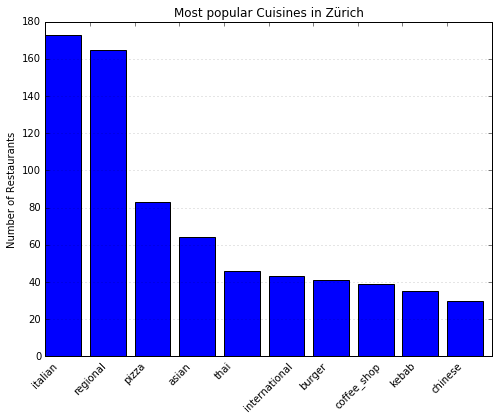

In [12]:
# sql query
sql_query = """
SELECT nodes_tags.value, count(*) AS num
FROM nodes, nodes_tags
WHERE nodes_tags.node_id = nodes.node_id
AND nodes_tags.key="cuisine"
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 10;
"""

conn = sqlite3.connect('zurich.db')
cursor = conn.cursor()

cursor.execute(sql_query)
results = cursor.fetchall()

conn.close()

# index, labels and counts for the bar plot
ind = range(len(results))
l, c = [l for l, c in results], [c for l, c in results]

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(ind, c)
ax.set(title="Most popular Cuisines in Zürich", ylabel="Number of Restaurants", xticks=ind)
ax.set_xticklabels(l, rotation=45)
ax.grid(alpha=0.4, axis='y')

plt.show()

### Sports

Most popular sports found in Zürich:

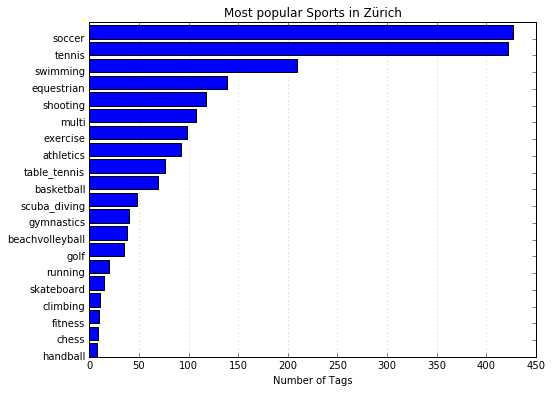

In [13]:
# sql query
sql_query = """
SELECT value, count(*) AS num
FROM (SELECT value FROM nodes_tags WHERE key="sport"
      UNION ALL SELECT value FROM ways_tags WHERE key="sport"
      UNION ALL SELECT value FROM relations_tags WHERE key="sport")
GROUP BY value
ORDER BY num DESC
LIMIT 20;
"""

conn = sqlite3.connect('zurich.db')
cursor = conn.cursor()

cursor.execute(sql_query)
results = cursor.fetchall()

conn.close()

# index, labels and counts for the horizontal bar plot
ind = range(len(results))
l, c = [l for l, c in results[::-1]], [c for l, c in results[::-1]]

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(ind, c)
ax.set(title="Most popular Sports in Zürich", xlabel="Number of Tags", yticks=ind)
ax.set_yticklabels(l, rotation=0)
ax.grid(alpha=0.4, axis='x')

plt.show()

## Conclusion

The review of the OpenStreetMap data of the area around Zürich showed me that the data quality is already pretty high. I did not encounter any major problems regarding data validity and accuracy but just a few minor inconsistencies in formatting. While handling the large XML file is very inefficient and slow, once the data in transferred to the SQL database, the data can be querried in a really fast way trough the command line interface or the Python API.

During data analysis I looked at a few interesting features such as the different users that contributed to the data set and the different restaurants and sport centers available in Zürich. I also touched on the `mplleaflet` library for the display of geographical nodes on a interactive `JavaScript` map. Additionally, it could also be used for the visualisation of polygenic ways and relations.